# [Ссылка на kaggle](https://www.kaggle.com/code/soimmarylanabanana/hw2-sorokin)

In [ ]:
# !pip install pandas
# !pip install torch
# !pip install nltk
# !pip install tqdm
# !pip install seaborn
# !pip install numpy
# !pip install sklearn
# !pip install pymorphy2
# !pip install spacy
# !spacy download ru_core_news_md

In [2]:
from tqdm.notebook import tqdm
tqdm.pandas()
from string import punctuation
from collections import Counter

import nltk
nltk.download('punkt')

import torch
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import spacy
import pymorphy2
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize

morph = pymorphy2.MorphAnalyzer(lang='ru')
lemm = spacy.load('ru_core_news_md')
stopwords_rus = stopwords.words("russian")
punctuation += '—…«»'

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Скачиваем данные

In [3]:
!wget https://raw.githubusercontent.com/semensorokin/DLforNLP_course_material/master/Homework2/answers_subsample.csv

--2022-12-01 16:50:19--  https://raw.githubusercontent.com/semensorokin/DLforNLP_course_material/master/Homework2/answers_subsample.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28717126 (27M) [text/plain]
Saving to: ‘answers_subsample.csv’

answers_subsample.c 100%[===================>]  27.39M  --.-KB/s    in 0.1s    

2022-12-01 16:50:20 (233 MB/s) - ‘answers_subsample.csv’ saved [28717126/28717126]



In [4]:
!ls -l

total 28052
---------- 1 root root      263 Dec  1 16:49 __notebook_source__.ipynb
-rw-r--r-- 1 root root 28717126 Dec  1 16:50 answers_subsample.csv


In [5]:
!ls /kaggle/working

__notebook_source__.ipynb  answers_subsample.csv


In [220]:
data = pd.read_csv('answers_subsample.csv')
# так как предобработка заняла много времени, я сохранила лемматизированный датасет
# data = pd.read_csv('/kaggle/input/hw2-dataser/data.csv', index_col=0)

In [7]:
data['category'].value_counts()

law         70842
relax       52350
business    45914
food        43673
love        25000
Name: category, dtype: int64

# Предобученные эмбеддинги
[Источник](https://fasttext.cc/docs/en/crawl-vectors.html)  
Вы можете взять любые word2vec подобные эмббединги. Если вы хотите использовать elmo, bert, etc сначала попробуйте с word2vec подобными эмббедингами, а потом можете перейти к более сложным моделям.  
Ниже мы сначала скачиваем, а потом распоковываем эмбеддинги.

In [8]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
!gzip -d cc.ru.300.vec.gz

--2022-12-01 16:50:24--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306357571 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ru.300.vec.gz’

cc.ru.300.vec.gz    100%[===================>]   1.22G  20.6MB/s    in 69s     

2022-12-01 16:51:35 (17.9 MB/s) - ‘cc.ru.300.vec.gz’ saved [1306357571/1306357571]



In [9]:
!ls -l

total 4458144
---------- 1 root root        263 Dec  1 16:49 __notebook_source__.ipynb
-rw-r--r-- 1 root root   28717126 Dec  1 16:50 answers_subsample.csv
-rw-r--r-- 1 root root 4536408847 Jan 18  2019 cc.ru.300.vec


In [10]:
def remove_punctuation(text: str) -> str:
    for i in punctuation:
        text = text.replace(i, ' ')
    return text


def lemmatization(text: str) -> list:
    return [token.lemma_ for token in lemm(text)]


def preprocessing(text: str) -> str:
    lemm_text = remove_punctuation(text)
    lemm_text = lemmatization(lemm_text)
    return ' '.join(lemm_text)

In [ ]:
data['text_lemm'] = data['text'].progress_apply(preprocessing)

In [12]:
data.head()

,category,text,text_lemm
0,business,Могут ли в россельхозбанке дать в залог норков...,мочь ли в россельхозбанке дать в залог норковы...
1,law,Может ли срочник перевестись на контракт после...,мочь ли срочник перевестись на контракт после ...
2,business,Продажа недвижимости по ипотеки ? ( арестованы...,продажа недвижимость по ипотеки арестоват...
3,business,"В чем смысл криптовалюты, какая от неё выгода ...",в что смысл криптовалюты какой от неё выгода...
4,law,часть 1 статья 158 похитил телефон,часть 1 статья 158 похитить телефон


In [13]:
word2freq = {}
lengths = []

for text in tqdm(data['text_lemm']):
    tokens = text.split()
    lengths.append(len(tokens))
    
    for token in tokens:
        if token in word2freq:
            word2freq[token] += 1
        else:
            word2freq[token] = 1

  0%|          | 0/237779 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Распределение длин слов в текстах'}, xlabel='Длина предложения', ylabel='Доля'>

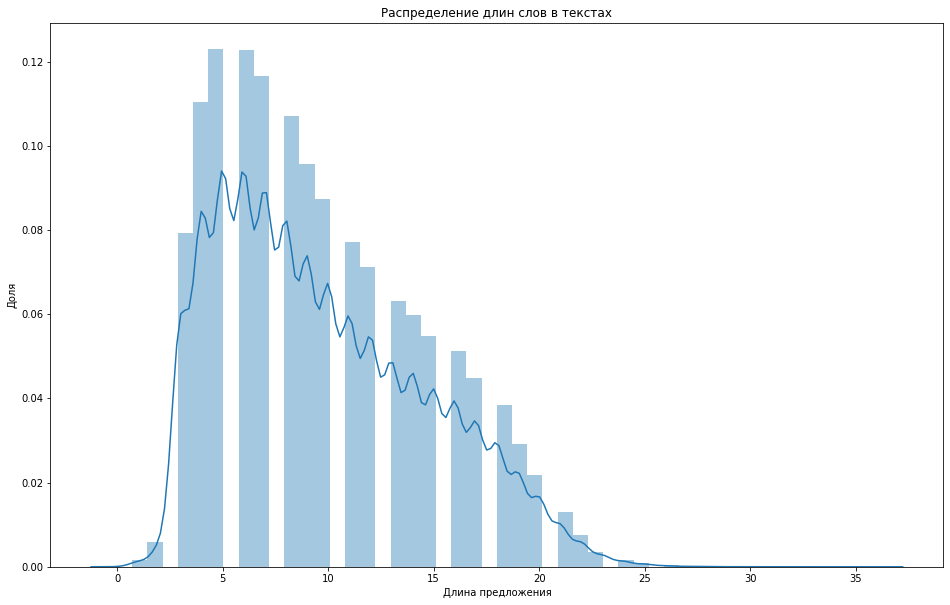

In [14]:
plt.figure(figsize=(16, 10))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sns.distplot(lengths)

In [15]:
upper_threshold = 32
lower_threshold = 3

correct_percent = len([sent_len for sent_len in lengths 
                       if sent_len <= upper_threshold and sent_len >= lower_threshold]) * 100 / len(lengths)

'{:.2f} % наших текстов входят в промежуток от {} до {} слов'.format(correct_percent, lower_threshold, upper_threshold)

'99.46 % наших текстов входят в промежуток от 3 до 32 слов'

In [16]:
len(word2freq)

98858

In [17]:
'{} слов, которые встречались 3 и менее раз'.format(len([word for word in word2freq if word2freq[word] <= 3]))

'77271 слов, которые встречались 3 и менее раз'

In [18]:
data.to_csv('data.csv')

# Читаем файл с эмбеддингами
### Этот файл с 300 числами для 2 000 000 слов и он может не влезть в память
Поэтому прочитаем только те слова, которые мы знаем

In [19]:
word2index = {'PAD': 0}
vectors = []
    
word2vec_file = open('cc.ru.300.vec')
    
n_words, embedding_dim = word2vec_file.readline().split()
n_words, embedding_dim = int(n_words), int(embedding_dim)

# Zero vector for PAD
vectors.append(np.zeros((1, embedding_dim)))

progress_bar = tqdm(desc='Read word2vec', total=n_words)

while True:
    line = word2vec_file.readline().strip()
    if not line:
        break
        
    current_parts = line.split()
    current_word = ' '.join(current_parts[:-embedding_dim])

    if current_word in word2freq:
        word2index[current_word] = len(word2index)

        current_vectors = current_parts[-embedding_dim:]
        current_vectors = np.array(list(map(float, current_vectors)))
        current_vectors = np.expand_dims(current_vectors, 0)

        vectors.append(current_vectors)
    progress_bar.update(1)

progress_bar.close()
word2vec_file.close()

vectors = np.concatenate(vectors)

Read word2vec:   0%|          | 0/2000000 [00:00<?, ?it/s]

In [20]:
len(word2index)

66724

In [21]:
unk_words = [word for word in word2freq if word not in word2index]
unk_counts = [word2freq[word] for word in unk_words]
n_unk = sum(unk_counts) * 100 / sum(list(word2freq.values()))

sub_sample_unk_words = {word: word2freq[word] for word in unk_words}
sorted_unk_words = list(sorted(sub_sample_unk_words, key=lambda x: sub_sample_unk_words[x], reverse=True))

print('Мы не знаем {:.2f} % слов в датасете'.format(n_unk))
print('Количество неизвестных слов {} из {}, то есть {:.2f} % уникальных слов в словаре'.format(
    len(unk_words), len(word2freq), len(unk_words) * 100 / len(word2freq)))
print('В среднем каждое встречается {:.2f} раз'.format(np.mean(unk_counts)))
print()
print('Топ 5 невошедших слов:')

for i in range(5):
    print(sorted_unk_words[i], 'с количеством вхождениий -', word2freq[sorted_unk_words[i]])

Мы не знаем 1.68 % слов в датасете
Количество неизвестных слов 32135 из 98858, то есть 32.51 % уникальных слов в словаре
В среднем каждое встречается 1.21 раз

Топ 5 невошедших слов:
исковый с количеством вхождениий - 240
отварный с количеством вхождениий - 49
дошик с количеством вхождениий - 43
пирожный с количеством вхождениий - 41
егрн с количеством вхождениий - 41


# Потеря 1.68 % слов в датасете

- 128 - размер батча
- 64 - количество слов
- 1024 - эмбеддинг слова

In [22]:
x = torch.rand(128, 64, 1024)

In [23]:
lstm = torch.nn.LSTM(1024, 512, batch_first=True)

In [24]:
%%timeit

pred = lstm(x)

503 ms ± 63.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# А что GPU?

In [25]:
print('Доступна ли видеокарта:', torch.cuda.is_available())
print('Если недоступна, поменяйте runtime, если в колабе')

Доступна ли видеокарта: True
Если недоступна, поменяйте runtime, если в колабе


In [114]:
# универсальных способ задать device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# если доступна gpu, то давайте ее использовать, но в этом задании должны использовать

In [27]:
# перенесли x на gpu
x_gpu = x.to(device)

In [28]:
# зададим lstm на gpu
lstm_gpu = torch.nn.LSTM(1024, 512, batch_first=True)
lstm_gpu = lstm_gpu.to(device)

In [29]:
%%timeit

pred = lstm_gpu(x_gpu)

9.99 ms ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# У меня на 1070 TI скорость уменьшилась с 381мс до 41мс, то есть в 9.29 раз

In [30]:
# если у нас модель на гпу, а то, что мы туда подаем нет, то работать не будет
# справедлива и обратная ситуация

# выскочит ошибка
# посмотрите на нее, возможно, вы еще встретитесь
# pred = lstm_gpu(x)

# Важные и не очень интуитивные моменты про LSTM и CNN в торче

По умолчанию LSTM принимает данные с такой размерностью:
```python
(seq_len, batch, input_size)
```
Сделано это с целью оптимизации на более низком уровне.  
Мы оперируем такими объектами:
```python
(batch, seq_len, input_size)
```
Чтобы LSTM у нас заработала правильно, мы можем либо передать параметр ```batch_first=True``` во время инициализации слоя,
либо транспонировать (поменять) первую и вторую размерность у нашего x перед подачей в слой.  
[Подробнее про LSTM](https://pytorch.org/docs/stable/nn.html#lstm)

- 128 - размер батча
- 64 - количество слов
- 1024 - эмбеддинг слова

In [31]:
# первый способ
lstm = torch.nn.LSTM(1024, 512, batch_first=True)
pred, mem = lstm(x)

In [32]:
pred.shape

torch.Size([128, 64, 512])

In [33]:
lstm = torch.nn.LSTM(1024, 512)

# меняем размерность batch и seq_len местами
x_transposed = x.transpose(0, 1)
pred_transposed, mem = lstm(x_transposed)

In [34]:
# у нас все еще осталась размерность (seq_len, batch, input_size)
pred_transposed.shape

torch.Size([64, 128, 512])

In [35]:
# просто транспонируем еще раз
pred = pred_transposed.transpose(0, 1)
pred.shape

torch.Size([128, 64, 512])

## Conv1d & MaxPool1d
Примерно такая же ситуация происходит со сверточными слоями и пулингами.  
1d реализация как раз для текстов, в ней матрица-фильтр ходит только по одной размерности.  
[Подробнее про CNN](https://pytorch.org/docs/stable/nn.html#conv1d)  
[Подробнее про пулинг](https://pytorch.org/docs/stable/nn.html#maxpool1d)  
Ожидается такая размерность:
```python
(batch, input_size, seq_len)
```
Мы все еще хоти подавать такую размерность:
```python
(batch, seq_len, input_size)
```
В случае со свертками и пулингами у нас есть вариант только транспонировать x перед подачей и транспонировать полученный результат. Обратите внимание, что транспонируем мы первую и вторую размерность (индексация с нуля).

In [36]:
x.shape

torch.Size([128, 64, 1024])

- 128 - размер батча
- 64 - количество слов
- 1024 - эмбеддинг слова

In [37]:
# in_channels - размер входных эмбеддингов
# out_channels - количество/какой размер эмбеддингов мы хотим получить
# kernel_size - размер окна/н-граммы
cnn = torch.nn.Conv1d(in_channels=1024, out_channels=512, kernel_size=3)

In [38]:
# выпадет ошибка, посмотрите какая
pred = cnn(x)

RuntimeError: Given groups=1, weight of size [512, 1024, 3], expected input[128, 64, 1024] to have 1024 channels, but got 64 channels instead

In [39]:
x_transposed = x.transpose(1, 2)
x_transposed.shape
# перевели в (batch, input_size, seq_len)

torch.Size([128, 1024, 64])

In [40]:
pred_transposed = cnn(x_transposed)
pred_transposed.shape
# осталась разрмерность (batch, output_size, seq_len)

torch.Size([128, 512, 62])

In [41]:
# переведем обратно в (batch, seq_len, input_size)
pred = pred_transposed.transpose(1, 2)
pred.shape

torch.Size([128, 62, 512])

# Подготовим данные в DataLoader

In [42]:
from torch.utils.data import Dataset, DataLoader

In [43]:
'UNK' in word2index

False

In [44]:
data.head()

,category,text,text_lemm
0,business,Могут ли в россельхозбанке дать в залог норков...,мочь ли в россельхозбанке дать в залог норковы...
1,law,Может ли срочник перевестись на контракт после...,мочь ли срочник перевестись на контракт после ...
2,business,Продажа недвижимости по ипотеки ? ( арестованы...,продажа недвижимость по ипотеки арестоват...
3,business,"В чем смысл криптовалюты, какая от неё выгода ...",в что смысл криптовалюты какой от неё выгода...
4,law,часть 1 статья 158 похитил телефон,часть 1 статья 158 похитить телефон


# Замапим категории в индексы

In [45]:
cat_mapper = {cat: n for n, cat in enumerate(data.category.unique())}

In [46]:
cat_mapper

{'business': 0, 'law': 1, 'love': 2, 'relax': 3, 'food': 4}

In [47]:
data.category = data.category.map(cat_mapper)

In [48]:
data.head()

,category,text,text_lemm
0,0,Могут ли в россельхозбанке дать в залог норков...,мочь ли в россельхозбанке дать в залог норковы...
1,1,Может ли срочник перевестись на контракт после...,мочь ли срочник перевестись на контракт после ...
2,0,Продажа недвижимости по ипотеки ? ( арестованы...,продажа недвижимость по ипотеки арестоват...
3,0,"В чем смысл криптовалюты, какая от неё выгода ...",в что смысл криптовалюты какой от неё выгода...
4,1,часть 1 статья 158 похитил телефон,часть 1 статья 158 похитить телефон


# Читалка данных

## Что происходит ниже
1. Мы задаем x_data, y_data (таргеты), word2index (маппер из слова в индекс слова), sequence_length (максимальная длина последовательности, если больше, ограничить ею), pad_token (токен паддинга и задаем его индекс pad_index).
1. Загружаем данные:
    1. Проходимся по датасету
    1. Предобрабатываем каждый текст в датасете
    1. Индексируем его
    1. Паддим до нужной длины
1. Когда нам нужно достать пример из датасета мы берем индексированный ```x``` и соответствующий этому индексу ```y```, наш ```x``` также паддим (или ограничиваем длину) и переводим в ```torch.Tensor(x).long()```. Для ```y``` этого делать не потребуется, в dataloader'е таргеты преобразуются в тензор сами.


In [49]:
class WordData(Dataset):
    
    def __init__(self, x_data, y_data, word2index, sequence_length=32, pad_token='PAD', verbose=True):
        
        super().__init__()
        
        self.x_data = []
        self.y_data = y_data
        
        self.word2index = word2index
        self.sequence_length = sequence_length
        
        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]
        
        self.load(x_data, verbose=verbose)
        
    @staticmethod
    def process_text(text):
        words = preprocessing(text)
        return words
        
    def load(self, data, verbose=True):
        data_iterator = tqdm(data, desc='Loading data', disable=not verbose)
        for text in data_iterator:
            # words = self.process_text(text)
            indexed_words = self.indexing(text.split())
            self.x_data.append(indexed_words)
    
    def indexing(self, tokenized_text):

        # здесь мы не используем токен UNK, потому что мы его специально не учили
        # становится непонятно какой же эмбеддинг присвоить неизвестному слову,
        # поэтому просто выбрасываем наши неизветсные слова
        
        return [self.word2index[word] for word in tokenized_text if word in self.word2index]
    
    def padding(self, sequence):
        
        # Ограничить длину self.sequence_length
        # если длина меньше максимально - западить
        if len(sequence)< self.sequence_length:
            add_pad = self.sequence_length - len(sequence)
            return sequence+[self.pad_index]*add_pad
        else:
            return sequence[:self.sequence_length]
    
    def __len__(self):
        
        return len(self.x_data)
    
    def __getitem__(self, idx):
        
        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()
        
        y = self.y_data[idx]
        
        return x, y

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [51]:
x_train, x_validation, y_train, y_validation = train_test_split(data.text_lemm, data.category, test_size=0.1)

train_dataset = WordData(list(x_train), list(y_train), word2index)
train_loader = DataLoader(train_dataset, batch_size=64)

validation_dataset = WordData(list(x_validation), list(y_validation), word2index)
validation_loader = DataLoader(validation_dataset, batch_size=64)

Loading data:   0%|          | 0/214001 [00:00<?, ?it/s]

Loading data:   0%|          | 0/23778 [00:00<?, ?it/s]

In [52]:
for x, y in train_loader:
    break

In [61]:
x[0]

tensor([  12,  912,    8,   21, 2081,   64,  997,    2, 5369,  902,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [57]:
y

tensor([2, 1, 3, 0, 1, 3, 4, 1, 2, 4, 1, 1, 2, 1, 4, 3, 0, 0, 0, 2, 3, 3, 2, 4,
        3, 3, 4, 3, 1, 1, 3, 0, 2, 1, 1, 2, 3, 0, 1, 0, 1, 4, 0, 4, 3, 1, 1, 1,
        1, 0, 2, 4, 0, 1, 1, 0, 3, 3, 0, 2, 3, 3, 1, 3])

# Обучить нейронку

In [205]:
import random
import os


def set_seed(seed: int=42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [214]:
from math import sqrt


class model_with_att(torch.nn.Module):
    def __init__(self, matrix_w, n): # n - количетсво категорий
        super().__init__()

        self.n = n
        self.emb_layer = torch.nn.Embedding.from_pretrained(torch.Tensor(matrix_w))
        self.emb_norm = torch.nn.LayerNorm(300)

        # задайте лстм, можно 2 уровня, лучше бидирекциональный
        self.LSTM = torch.nn.LSTM(300, 256, num_layers=2, bidirectional=True, batch_first=True)
        
        # три линейных преобразования, размерность совпадает с выходом из лстм (если БИлстм то надо умножить ее на 2)
        self.q_proj = torch.nn.Linear(in_features=512, out_features=256, bias=True)
        self.k_proj = torch.nn.Linear(in_features=512, out_features=256, bias=True)
        self.v_proj = torch.nn.Linear(in_features=512, out_features=256, bias=True)

        self.att_soft = torch.nn.Softmax(dim=2)
        
        # три конволюционных фильтра с разными ядрами (3,4,5), чтобы всякие нграммы ловить
        self.cnn_3gr = torch.nn.Conv1d(256, 128, kernel_size=(3,), stride=(1,))
        self.cnn_4gr = torch.nn.Conv1d(256, 128, kernel_size=(4,), stride=(1,))
        self.cnn_5gr = torch.nn.Conv1d(256, 128, kernel_size=(5,), stride=(1,))

        # сверху накидываем два полносвязных слоя для классификации
        self.linear = torch.nn.Sequential(
            torch.nn.LayerNorm(384),
            torch.nn.Linear(in_features=384, out_features=256, bias=True),
            torch.nn.Mish(),
            torch.nn.LayerNorm(256),
            torch.nn.Linear(in_features=256, out_features=64, bias=True),
            torch.nn.Mish(),
            torch.nn.LayerNorm(64),
            torch.nn.Linear(in_features=64, out_features=n)
        )
        
    def forward(self, x):
        x_emb = self.emb_layer(x)
        x_emb = self.emb_norm(x_emb)
        # применим лстм, не забываем что на выходе у него много всяких последовательностей, нам нужна только эта
        x, _ = self.LSTM(x_emb) 

        # применим линейные преобразования для селф-эттеншена
        x_q = self.q_proj(x) 
        x_k = self.k_proj(x)
        x_v = self.v_proj(x)

        att_scores = torch.bmm(x_q, x_k.transpose(1, 2)) / sqrt(256)
        att_dist = self.att_soft(att_scores) # накидываем софтмакс
        attention_vectors = torch.bmm(att_dist, x_v)

        x_att = attention_vectors.transpose(2,1) # транспонируем для конволючионнах фильтров

        x_cnn3 = self.cnn_3gr(x_att)
        x_cnn4 = self.cnn_4gr(x_att)
        x_cnn5 = self.cnn_5gr(x_att)

        frst, _ =  x_cnn3.max(dim= -1,) # cделаем макс пуллинг
        sc, _ = x_cnn4.max(dim= -1,)
        thr, _ = x_cnn5.max(dim= -1,)

        x_cat = torch.cat((frst, sc, thr), dim=-1) # а теперь объединим результаты

        return self.linear(x_cat)

In [215]:
n_classes = data.category.unique().shape[0]
n_classes

5

In [216]:
set_seed()
model = model_with_att(vectors, n_classes)

Random seed set as 42


In [217]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [218]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [219]:
epochs = 10
losses = []
best_test_loss = 10.
test_f1 = []

for n_epoch in range(epochs):
    train_losses = []
    test_losses = []
    test_targets = []
    test_pred_class = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    model.train()
    
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))
        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    model.eval()
    
    for x, y in validation_loader:
        
        x = x.to(device)

        with torch.no_grad():

            pred = model(x)
            pred = pred.cpu()

            test_targets.append(y.numpy())
            test_pred_class.append(np.argmax(pred, axis=1))

            loss = criterion(pred, y)
            test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)

    test_targets = np.concatenate(test_targets).squeeze()
    test_pred_class = np.concatenate(test_pred_class).squeeze()

    f1 = f1_score(test_targets, test_pred_class, average='micro')

    test_f1.append(f1)
    
    print()
    print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(train_losses), mean_test_loss))
    print('F1 test - {:.3f}'.format(f1))
        
    # Early stopping:
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break

Epoch 1:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.497, test - 0.443
F1 test - 0.840


Epoch 2:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.411, test - 0.438
F1 test - 0.845


Epoch 3:   0%|          | 0/214001 [00:00<?, ?it/s]


Losses: train - 0.361, test - 0.477
F1 test - 0.843
Early stopping


# Если вы запускаете много раз колаб окна и ткдм начинает беситься, можно запустить окно ниже, ткдм обновится и все снова станет хорошо

In [ ]:
for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)

# Оценка
1. Добрались сюда - очень хорошо - получилась такая же точность или около того - 7 баллов.
2. Поставили эксперименты и повысили точность относительно своей и не ниже F1 test - 0.841 - 8 баллов.
3. Запустили бертовую тетрадку и разобрались. Получился сравнимый результат - 10 баллов 

# Эксперименты

1. Добавила в препроцессинг лемматизацию
2. AdamW вместо Adam
3. В конце более глубокая сетка с нормализацией и Mish

``torch.nn.Sequential(
            torch.nn.LayerNorm(384),
            torch.nn.Linear(in_features=384, out_features=256, bias=True),
            torch.nn.Mish(),
            torch.nn.LayerNorm(256),
            torch.nn.Linear(in_features=256, out_features=64, bias=True),
            torch.nn.Mish(),
            torch.nn.LayerNorm(64),
            torch.nn.Linear(in_features=64, out_features=n)
        )``
        
4. Нормализация эмбеддингов